## **1. Preparación del Notebook 🐣**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Cargar los datos
train_df = pd.read_csv('/kaggle/input/prediccion-de-sufrir-enfermedades-coronarias/train.csv')
test_public_df = pd.read_csv('/kaggle/input/prediccion-de-sufrir-enfermedades-coronarias/test_public.csv')
test_private_df = pd.read_csv('/kaggle/input/prediccion-de-sufrir-enfermedades-coronarias/test_private.csv')

# Mostrar las primeras filas del dataset de entrenamiento
print("Datos de entrenamiento:")
print(train_df.head())

Datos de entrenamiento:
   CHD_OR_MI  SEX  AGE  HEALTH  PHYSICAL_HEALTH  MENTAL_HEALTH  \
0        1.0    1   34     1.0              1.0            2.0   
1        0.0    1   76     1.0              1.0            1.0   
2        1.0    2   69     1.0              1.0            1.0   
3        1.0    2   36     1.0              1.0            1.0   
4        1.0    2   21     1.0              1.0            2.0   

   PHYSICAL_ACTIVITIES  BLOOD_PRESSURE  HIGH_CHOLESTEROL  SKIN_CANCER  ...  \
0                  1.0             1.0               2.0          2.0  ...   
1                  2.0             2.0               1.0          1.0  ...   
2                  2.0             2.0               2.0          2.0  ...   
3                  1.0             1.0               2.0          2.0  ...   
4                  1.0             1.0               1.0          2.0  ...   

   SMOKE  TABACCO_PRODUCTS  E_CIGARETTES  HEAVY_DRINKERS  HIV  FRUITS  \
0    2.0               3.0           

## **2. Análisis Exploratorio de Datos (EDA)**

Primeras filas del dataset de entrenamiento:
   CHD_OR_MI  SEX  AGE  HEALTH  PHYSICAL_HEALTH  MENTAL_HEALTH  \
0        1.0    1   34     1.0              1.0            2.0   
1        0.0    1   76     1.0              1.0            1.0   
2        1.0    2   69     1.0              1.0            1.0   
3        1.0    2   36     1.0              1.0            1.0   
4        1.0    2   21     1.0              1.0            2.0   

   PHYSICAL_ACTIVITIES  BLOOD_PRESSURE  HIGH_CHOLESTEROL  SKIN_CANCER  ...  \
0                  1.0             1.0               2.0          2.0  ...   
1                  2.0             2.0               1.0          1.0  ...   
2                  2.0             2.0               2.0          2.0  ...   
3                  1.0             1.0               2.0          2.0  ...   
4                  1.0             1.0               1.0          2.0  ...   

   SMOKE  TABACCO_PRODUCTS  E_CIGARETTES  HEAVY_DRINKERS  HIV  FRUITS  \
0    2.0        

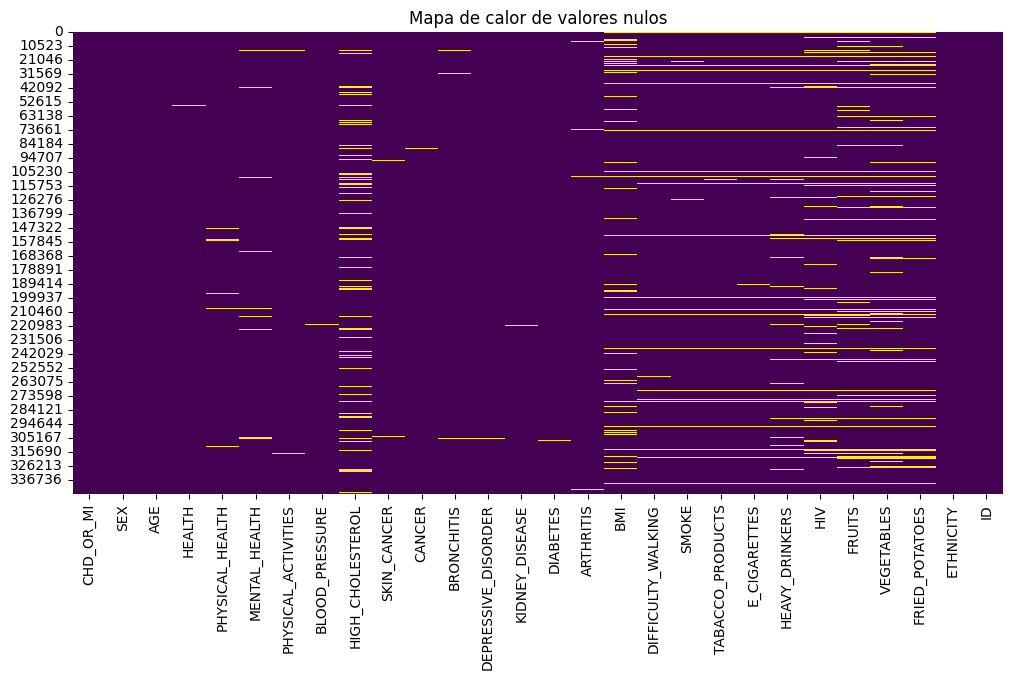

In [2]:
# Visualizar las primeras filas del dataset
print("Primeras filas del dataset de entrenamiento:")
print(train_df.head())

# Analizar la distribución de la variable objetivo
print("\nDistribución de la variable objetivo:")
print(train_df['CHD_OR_MI'].value_counts())

# Generar estadísticas descriptivas
print("\nEstadísticas descriptivas del dataset de entrenamiento:")
print(train_df.describe())

# Identificar valores nulos
print("\nValores nulos en el dataset de entrenamiento:")
print(train_df.isnull().sum())

# Visualizar valores nulos con un heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title('Mapa de calor de valores nulos')
plt.show()

## **3. Preprocesamiento**
**a) Imputación de valores nulos:**
* Decide estrategias para cada columna (media, mediana, moda o eliminación).
* Usa **SimpleImputer** de scikit-learn o **fillna()** de pandas.

**b) Codificación de variables categóricas:**
* Usa **OneHotEncoder** o **LabelEncoder** para convertir variables categóricas en numéricas.

**c) Escalado:**
* Aplica escalado con **StandardScaler** o **MinMaxScaler** para las columnas numéricas si es necesario.

**d) Selección de características:**
* Realiza un análisis de correlación usando **df.corr()**.
* Usa métodos como **SelectKBest** o algoritmos basados en árboles para determinar características importantes.

In [3]:
# Definir las columnas numéricas y categóricas
numeric_features = ['AGE', 'PHYSICAL_HEALTH', 'MENTAL_HEALTH', 'BMI']
categorical_features = ['SEX', 'HEALTH', 'PHYSICAL_ACTIVITIES', 'BLOOD_PRESSURE', 'HIGH_CHOLESTEROL', 
                        'SKIN_CANCER', 'CANCER', 'BRONCHITIS', 'DEPRESSIVE_DISORDER', 'KIDNEY_DISEASE', 
                        'DIABETES', 'ARTHRITIS', 'DIFFICULTY_WALKING', 'SMOKE', 'TABACCO_PRODUCTS', 
                        'E_CIGARETTES', 'HEAVY_DRINKERS', 'HIV', 'FRUITS', 'VEGETABLES', 'FRIED_POTATOES', 
                        'ETHNICITY']

# Crear transformadores para las columnas numéricas y categóricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar los transformadores en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Crear un pipeline con preprocesamiento y SMOTE
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42))
])

# Separar características y variable objetivo
X = train_df.drop(columns=['CHD_OR_MI', 'ID'])
y = train_df['CHD_OR_MI']

# Preprocesar los datos
X_resampled, y_resampled = pipeline.fit_resample(X, y)

## **4. Balanceo de Clases**
Implementa técnicas como:

* Submuestreo de la clase mayoritaria.
* Sobremuestreo con SMOTE (imbalanced-learn).
* Aplicación de ponderación en la función de pérdida del modelo.

Ya hemos aplicado SMOTE en el paso anterior.

## **5. Entrenamiento del Modelo**
**a) Aqui dividimos los datos de entrenamiento y validación usando** ***train_test_split()***.

**b) Prueba de varios modelos:**
* Árboles de decisión, Random Forest, Gradient Boosting, XGBoost, LightGBM, etc.
  
**c) Evaluamos el modelo mediante la métrica F1-Score.**

**d) Por último realiza la optimización de hiperparámetros con Grid Search o Random Search. Esto es crucial para maximizar el redimiento del modelo y así encontrar la mejor combinación.**

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# Definir los modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Evaluar cada modelo usando validación cruzada
for name, model in models.items():
    scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='f1')
    print(f"{name} F1-score promedio: {scores.mean()}")

Logistic Regression F1-score promedio: 0.7670031901481845
Decision Tree F1-score promedio: 0.9160007545745852
Naive Bayes F1-score promedio: 0.7200449419761619
Random Forest F1-score promedio: 0.9501693404648419
XGBoost F1-score promedio: 0.9449391265679177


## **6. Ensamblaje de modelos**
La idea es que al combinar varios modelos, se pueden compensar las debilidades de unos con las fortalezas de otros, logrando un modelo más robusto y preciso.

In [5]:
from sklearn.ensemble import VotingClassifier

# Crear un ensamblaje de modelos
ensemble_model = VotingClassifier(estimators=[
    ('lr', LogisticRegression(max_iter=1000, random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
], voting='soft')

# Evaluar el ensamblaje usando validación cruzada
ensemble_scores = cross_val_score(ensemble_model, X_resampled, y_resampled, cv=5, scoring='f1')
print("Ensamblaje F1-score promedio:", ensemble_scores.mean())

Ensamblaje F1-score promedio: 0.9359973250965947


## **7. Generación de Predicciones**

In [6]:
# Ajustar el modelo ensamblado con todos los datos de entrenamiento
ensemble_model.fit(X_resampled, y_resampled)

# Preprocesar el conjunto de prueba público
test_public_df_preprocessed = test_public_df.drop(columns=['ID', 'CHD_OR_MI'], errors='ignore')
test_public_df_imputed = preprocessor.transform(test_public_df_preprocessed)

# Preprocesar el conjunto de prueba privado
test_private_df_preprocessed = test_private_df.drop(columns=['ID', 'CHD_OR_MI'], errors='ignore')
test_private_df_imputed = preprocessor.transform(test_private_df_preprocessed)

# Hacer predicciones en ambos conjuntos de prueba
predictions_public = ensemble_model.predict(test_public_df_imputed)
predictions_private = ensemble_model.predict(test_private_df_imputed)

# Crear el archivo de envío combinando ambos conjuntos de prueba
submission_public = pd.DataFrame({
    'ID': test_public_df['ID'],
    'CHD_OR_MI': predictions_public
})

submission_private = pd.DataFrame({
    'ID': test_private_df['ID'],
    'CHD_OR_MI': predictions_private
})

submission = pd.concat([submission_public, submission_private])

# Guardar el archivo de envío
submission.to_csv('resultados.csv', index=False)

print("Archivo de envío creado: resultados.csv")

Archivo de envío creado: resultados.csv


## **8. Visualización de Resultados**

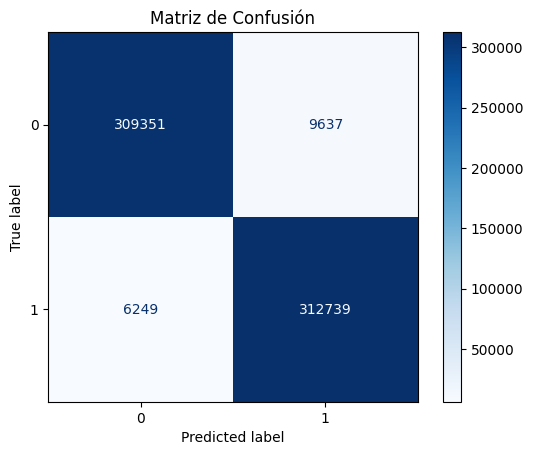

In [7]:
# Matriz de Confusión
y_true = y_resampled  # Reemplaza con los valores reales de tu conjunto de validación
y_pred = ensemble_model.predict(X_resampled)  # Reemplaza con las predicciones de tu conjunto de validación

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión')
plt.show()

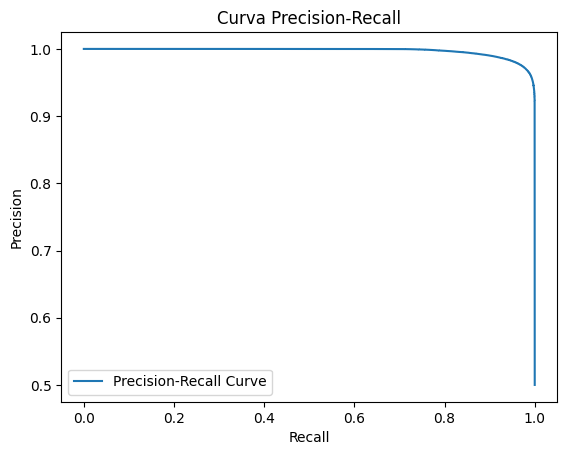

In [8]:
# Curva Precision-Recall
y_scores = ensemble_model.predict_proba(X_resampled)[:, 1]  # Reemplaza con las probabilidades de tu conjunto de validación

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.show()

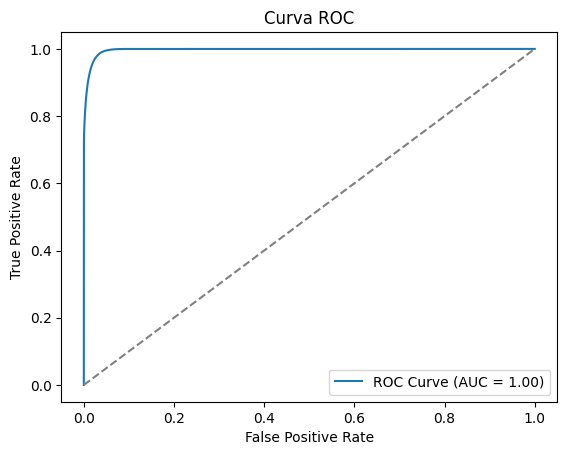

In [9]:
# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc_score = roc_auc_score(y_true, y_scores)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

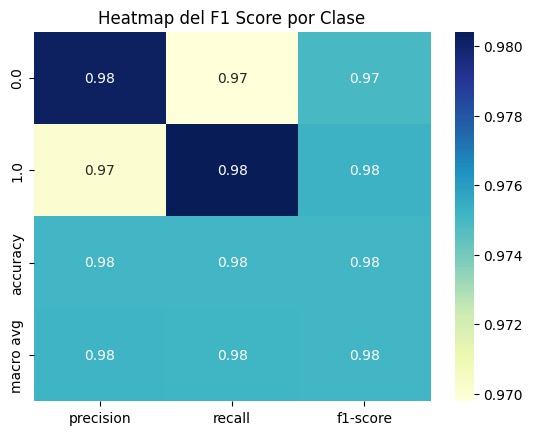

In [10]:
# Heatmap del F1 Score por Clase
report = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

sns.heatmap(df_report.loc[:, ["precision", "recall", "f1-score"]].iloc[:-1, :], annot=True, cmap="YlGnBu")
plt.title("Heatmap del F1 Score por Clase")
plt.show()

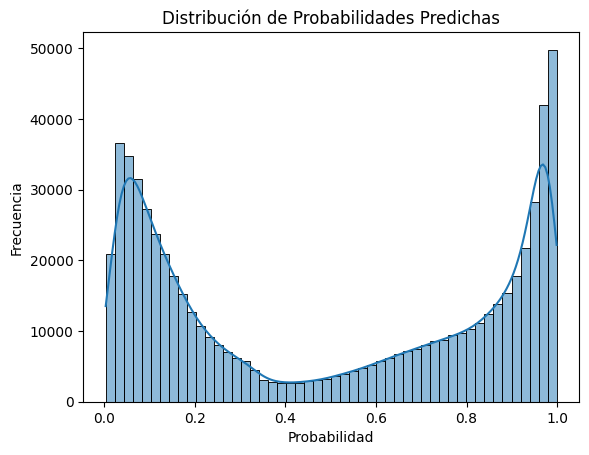

In [11]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Distribución de Probabilidades
sns.histplot(y_scores, bins=50, kde=True)
plt.title('Distribución de Probabilidades Predichas')
plt.xlabel('Probabilidad')
plt.ylabel('Frecuencia')
plt.show()

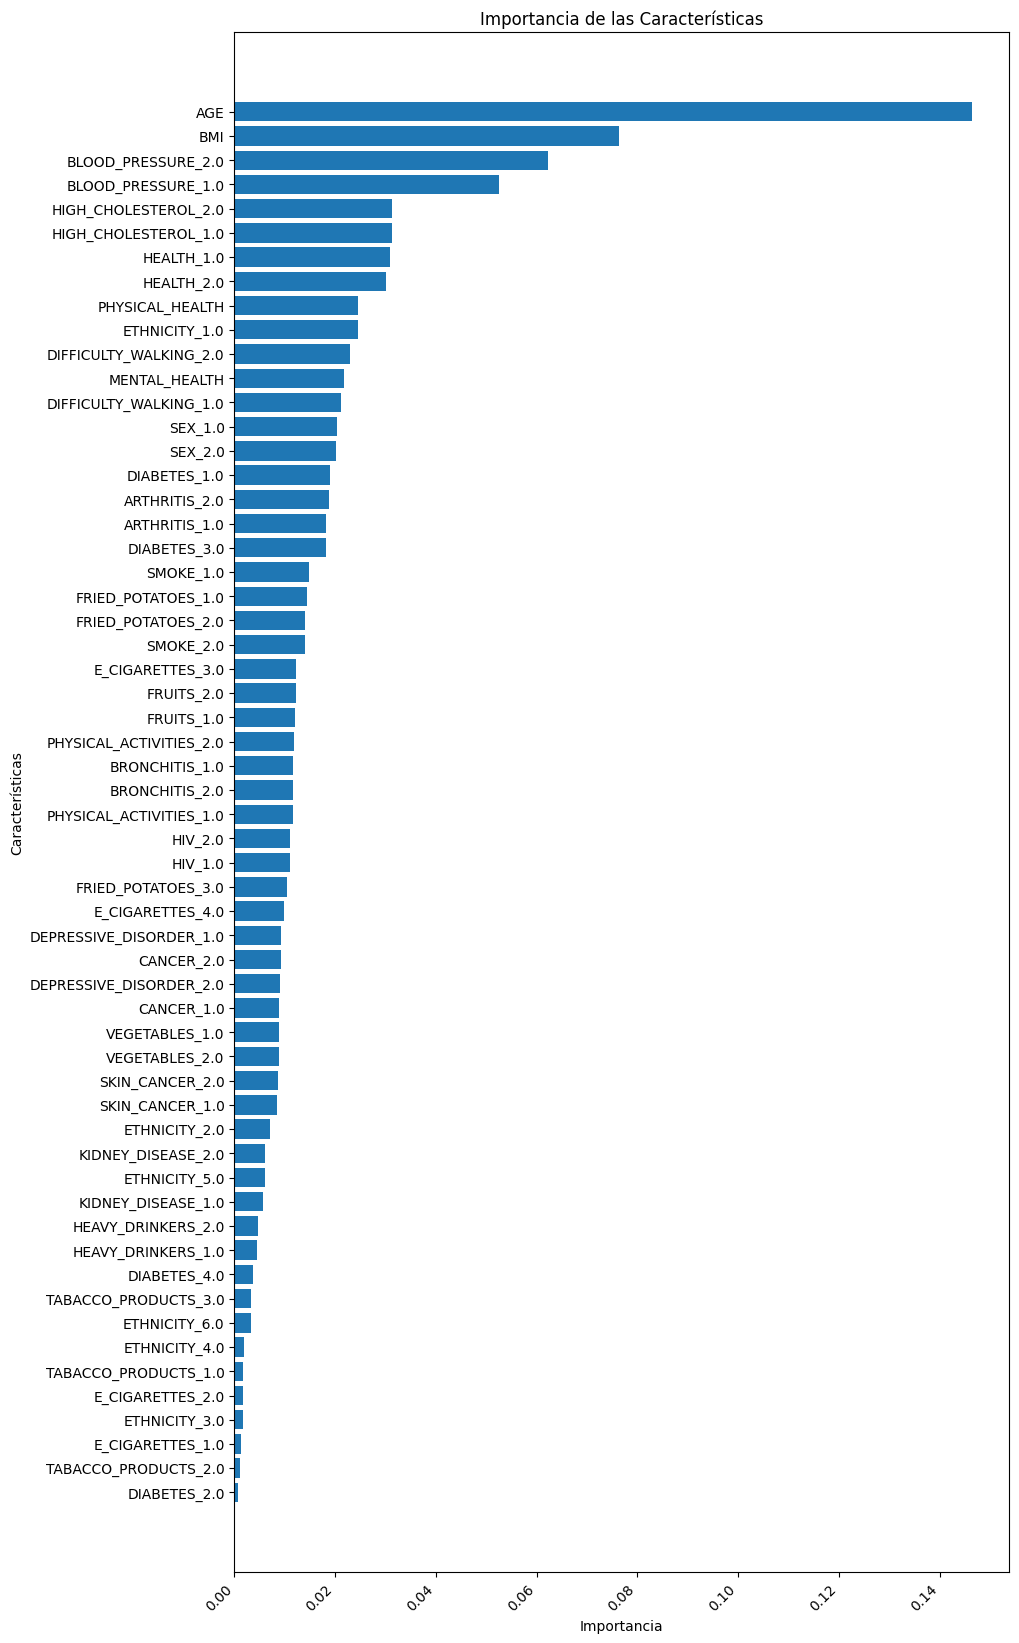

In [12]:
# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': numeric_features + list(preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)),
    'Importance': ensemble_model.named_estimators_['rf'].feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 20))  # Ajustar el tamaño de la figura
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.gca().invert_yaxis()  # Invertir el eje y para que las características más importantes estén en la parte superior
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x
plt.show()